In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import pyplot as plt
import yfinance as yf
import plotly.express as px

In [2]:
# importamos los datos prevaimente limpios y a los que les ha calculado el porcentaje de variación respecto al día haábil previo.
# si desea más información sobre como realizar este calculo en pandas sobre la data cruda puede revisar la función pandas.pct_change()
# df = pd.read_csv(r"C:\Users\maste\OneDrive\PDF\Maestria inteligencia Analitica de Datos\Aprendizaje no supervisado\sp500.csv")
# df = df.iloc[:,1:]
df = pd.read_csv(r"data/total_symbols.csv")
df = df.iloc[:,1:]
df.dropna(how="any", axis=1, inplace=True)
df = df.pct_change()
df = df.iloc[1:,:]



In [3]:
df.shape

(1130, 490)

In [4]:
from sklearn import covariance 

In [5]:
# Usaremos la sparse inverse covariance matrix para encontrar que variaciones de precio estan relacionadas condicionalmente con otras

model = covariance.GraphicalLassoCV(verbose=False)
X = df.copy()
X /= X.std(axis=0)

model.fit(X)

/home/ricardo/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:243: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = (- precision_[idx, idx]
/home/ricardo/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:245: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = (- precision_[idx, idx]
/home/ricardo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ricardo/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.229e-04
  warnings.warn('graphical_lasso: did not converge after '


GraphicalLassoCV()

In [6]:
emp_cov = np.dot(X.T, X) / len(df)
cv_ = model.covariance_


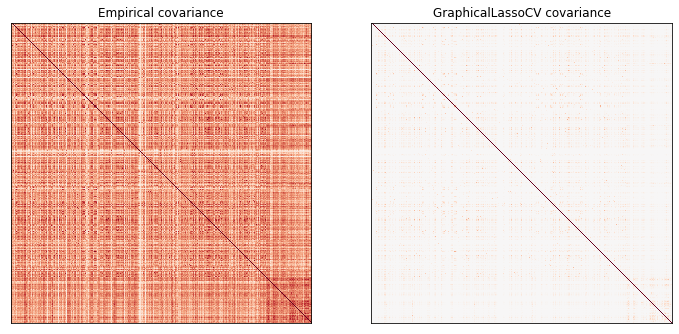

In [7]:
# comparando resultados para elección de GraphLassoCV
plt.figure(figsize=(20, 15))
plt.subplots_adjust(left=0.02, right=0.98)

# Graficando covarianzas
covs = [('Empirical', emp_cov),
        ('GraphicalLassoCV', cv_)]
vmax = cv_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)

In [8]:
# Seleccionado numero de alphas idoneo para el modelo
model.cv_results_["alphas"]

array([0.99299136, 0.7304864 , 0.68698218, 0.64606885, 0.60759212,
       0.57140688, 0.56443266, 0.55754356, 0.55073854, 0.54401658,
       0.53737666, 0.39531698, 0.29081187, 0.2139335 , 0.04609058,
       0.00992991, 0.        ])

In [9]:
model.alpha_

0.571406884714266

In [10]:
# reentrenado modelo con alphas recalculados
model = covariance.GraphicalLassoCV(alphas=6, cv=10, verbose=False)
model.fit(X)

/home/ricardo/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:243: RuntimeWarning: invalid value encountered in multiply
  precision_[indices != idx, idx] = (- precision_[idx, idx]
/home/ricardo/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:245: RuntimeWarning: invalid value encountered in multiply
  precision_[idx, indices != idx] = (- precision_[idx, idx]
/home/ricardo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:229: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/ricardo/.local/lib/python3.8/site-packages/sklearn/covariance/_graph_lasso.py:267: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.628e-04
  warnings.warn('graphical_lasso: did not converge after '


GraphicalLassoCV(alphas=6, cv=10)

In [11]:
# esta matriz inversa de covarianza es la que será nuestro insumo para realizar el siguinete paso, la clusterización. Lo anterior debido a que con esta matriz tenemos el cálculo de los precios que se comportan de forma similar.
model.covariance_

array([[9.99115044e-01, 2.40363999e-03, 8.12981588e-04, ...,
        1.89205466e-02, 3.48852342e-03, 6.19853259e-03],
       [2.40363999e-03, 9.99115044e-01, 9.09854818e-04, ...,
        1.89085585e-03, 9.47915662e-04, 1.36916277e-03],
       [8.12981588e-04, 9.09854818e-04, 9.99115044e-01, ...,
        6.08404546e-04, 2.81514097e-04, 4.92265516e-04],
       ...,
       [1.89205466e-02, 1.89085585e-03, 6.08404546e-04, ...,
        9.99115044e-01, 3.22540978e-03, 3.24864242e-03],
       [3.48852342e-03, 9.47915662e-04, 2.81514097e-04, ...,
        3.22540978e-03, 9.99115044e-01, 1.58201544e-03],
       [6.19853259e-03, 1.36916277e-03, 4.92265516e-04, ...,
        3.24864242e-03, 1.58201544e-03, 9.99115044e-01]])

In [12]:
from sklearn import cluster, covariance, manifold

In [13]:
#generando clusters
_, labels = cluster.affinity_propagation(model.covariance_)

/home/ricardo/.local/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [14]:
#identificando clusters
n_labels = labels.max()
names=[]
for stock in df.columns.tolist():
    names.append(stock)
names = np.array(names)
for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: A, MTD, TECH, WAT
Cluster 2: ABBV
Cluster 3: ABMD
Cluster 4: ALB
Cluster 5: ALGN
Cluster 6: AMCR
Cluster 7: ALLE, AME, APD, BLK, CPRT, CTAS, EXPD, IEX, J, MMM, NDSN, NKE, TROW, ROP, TDY
Cluster 8: AMGN
Cluster 9: BAC, BK, C, FRC, GS, JPM, MS, NTRS, RJF, SCHW, SIVB, STT, USB, WFC
Cluster 10: BALL
Cluster 11: BAX, BDX
Cluster 12: BBWI
Cluster 13: BIIB
Cluster 14: BMY
Cluster 15: CAG
Cluster 16: CBOE
Cluster 17: AMT, CCI, DLR, EQIX, SBAC
Cluster 18: CF, MOS
Cluster 19: CHD, CLX, KMB
Cluster 20: CHRW
Cluster 21: CMG
Cluster 22: AEE, AEP, ATO, AWK, CMS, D, DUK, ED, ES, EVRG, LNT, NEE, NI, SO, WEC, XEL
Cluster 23: APA, BKR, COP, CVX, DVN, EOG, FANG, HAL, HES, KMI, MRO, OKE, OXY, PXD, SLB, WMB, XOM
Cluster 24: CRL, CTLT, IQV
Cluster 25: CTRA
Cluster 26: CZR, PENN
Cluster 27: AAL, ALK, BA, DAL, LUV, UAL
Cluster 28: AXP, COF, DFS, DRI, KMX, MHK, RTX, SYF, SYY, TDG, WY, DXC
Cluster 29: DG
Cluster 30: DISH
Cluster 31: DLTR
Cluster 32: CHTR, DPZ
Cluster 33: ARE, DRE, PLD
Cluster 34: DVA

In [15]:
# generando 2D anidado para propositos de visualización
posicion_nodo = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=139)
anidado = posicion_nodo.fit_transform(X.T).T

(-0.09697697589672664, 0.15601499299700197)

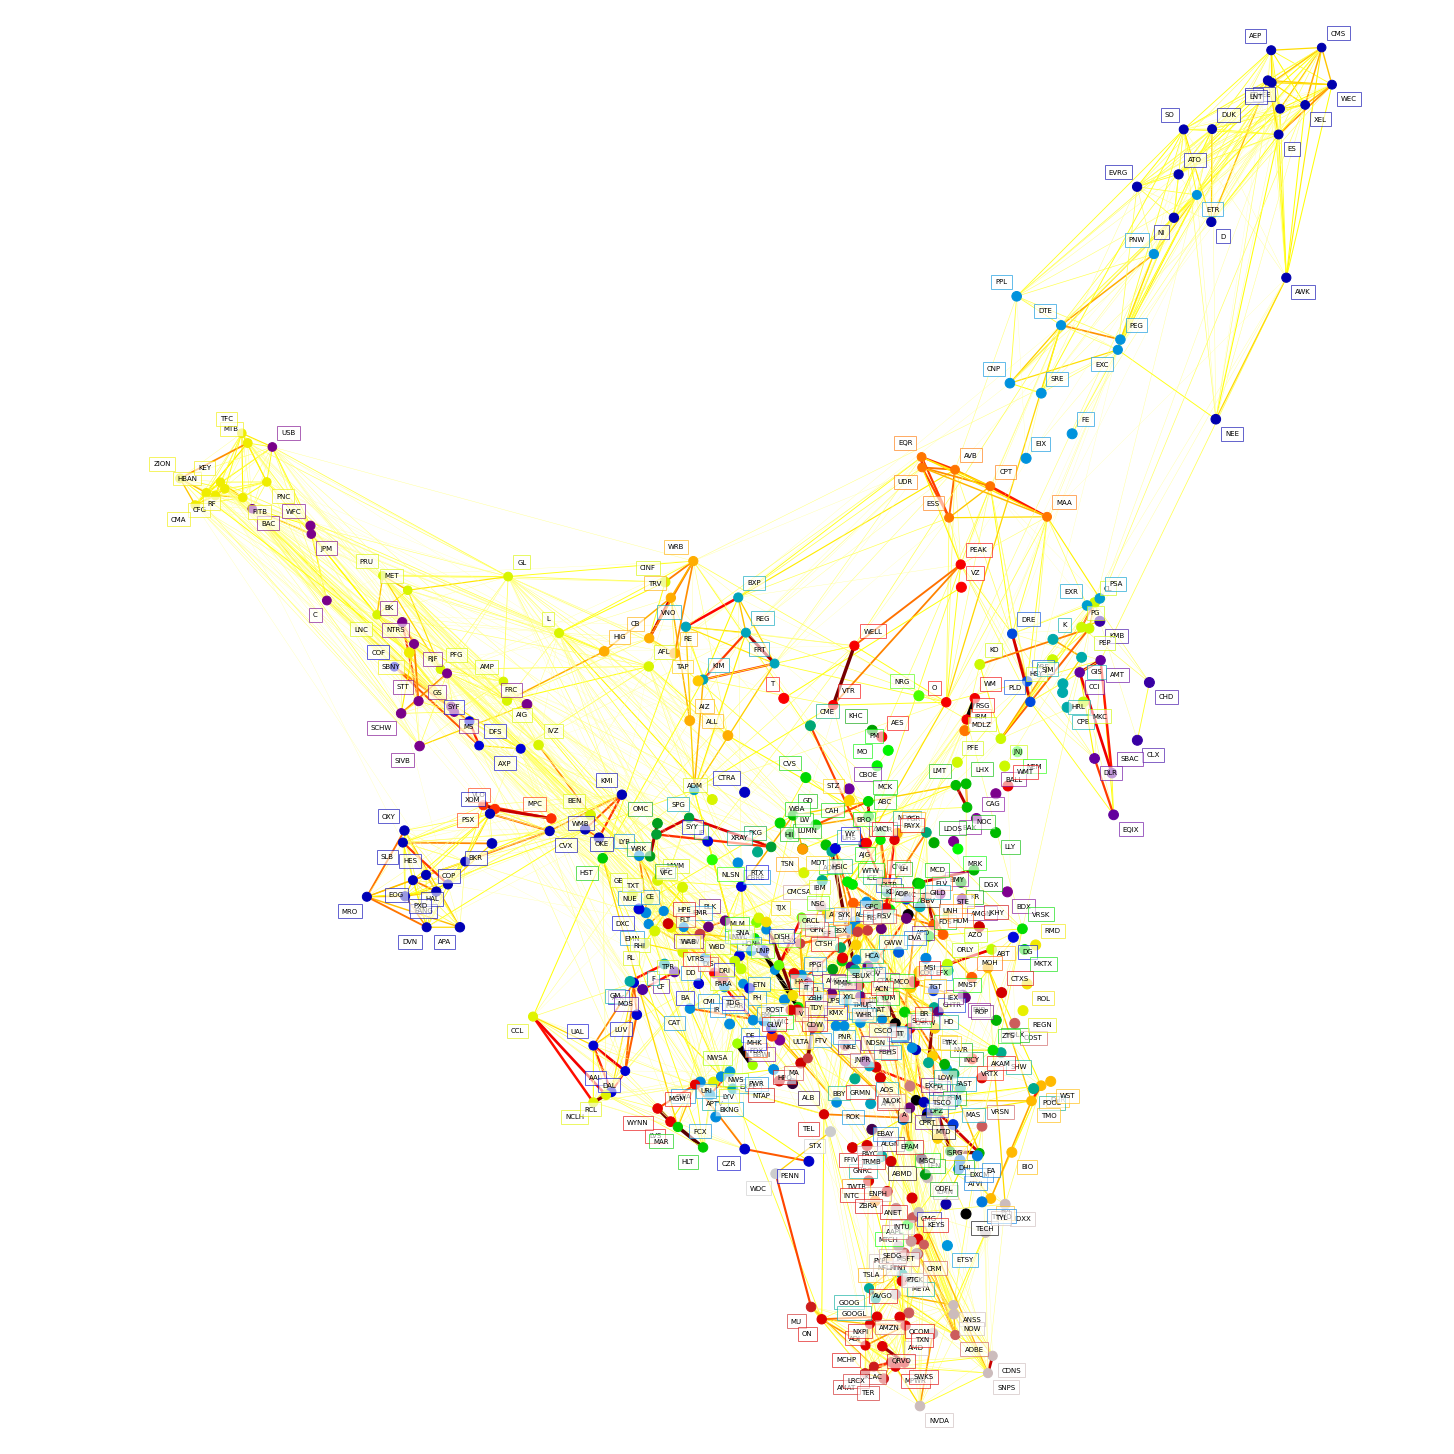

In [16]:
plt.figure(1, facecolor='w', figsize=(20, 20))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

corr_parciales = model.precision_.copy()
d = 1 / np.sqrt(np.diag(corr_parciales))
corr_parciales *= d
corr_parciales *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(corr_parciales, k=1)) > 0.02)
plt.scatter(anidado[0], anidado[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

inicio_idx, fin_idx = np.where(non_zero)
segmentos = [[anidado[:, start], anidado[:, stop]]
            for start, stop in zip(inicio_idx, fin_idx)]
values = np.abs(corr_parciales[non_zero])
lc = LineCollection(segmentos,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for indice, (name, label, (x, y)) in enumerate(
        zip(names, labels, anidado.T)):
    dx = x - anidado[0]
    dx[indice] = 1
    dy = y - anidado[1]
    dy[indice] = 1
    actual_dx = dx[np.argmin(np.abs(dy))]
    actual_dy = dy[np.argmin(np.abs(dx))]
    if actual_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if actual_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=7,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            bbox=dict(facecolor='w',
                    edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                    alpha=.6))
plt.xlim(anidado[0].min() - .15 * anidado[0].ptp(),
        anidado[0].max() + .10 * anidado[0].ptp(),)
plt.ylim(anidado[1].min() - .03 * anidado[1].ptp(),
        anidado[1].max() + .03 * anidado[1].ptp())

El siguiente paso consistirá en generar el proceso de clusterización tomando como insumo esta matriz de covarianza o esta matriz de similitud de ambos en los precios de cierre.

### Aplicación de resultados
De los resultados se observa que las compañias han sido agrupadas en clústers. Se toman las empresas TXN, AMZN, KLAC y LRCX para análisis pot su cercanía en el gráfico anterior.

In [2]:
# Compañias en clúster 134
symbols=['TXN', 'AMZN', 'KLAC', 'LRCX']

comp_134 = pd.DataFrame({
  'Symbol': symbols,
})
comps=pd.read_csv('data/Stocks in the SP 500 Index.csv')

comp_134=pd.merge(comp_134, comps, on='Symbol', how='left')

comp_134

,Symbol,Description,Category2,Category3,GICS Sector,Market cap,Dividend yield,Price to TTM earnings,Price to TTM sales,Price to book value,Action
0,TXN,Texas Instrument Inc,Common stocks,Large cap,Information Technology,"$167,537,382,446",2.48%,0.0,0.0,0.0,Analyze
1,AMZN,Amazon.Com Inc.,Common stocks,Large cap,Consumer Discretionary,"$1,474,954,186,550",0.00%,0.0,0.0,0.0,Analyze
2,KLAC,KLA-Tencor Corporation,Common stocks,Large cap,Information Technology,"$53,988,951,636",1.16%,0.0,0.0,0.0,Analyze
3,LRCX,Lam Research Corp,Common stocks,Large cap,Information Technology,"$70,794,601,180",1.17%,0.0,0.0,0.0,Analyze


In [3]:
# Tomando la base de datos original filtrando por las compañias del clúster 134
start_date='2018-01-01'
end_date='2022-06-30'
df_134 = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='B'),columns=['Date']) 
for i in symbols:
    data = yf.download(i, start=start_date, end=end_date)
    data=data.reset_index()
    data=data[['Date', 'Adj Close']]
    data.columns=['Date',i]
    df_134=pd.merge(df_134,data,on='Date', how='left')
# Descartar dias sin datos
df_134=df_134.dropna(axis = 0, how = 'any')
df_134

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,TXN,AMZN,KLAC,LRCX
1,2018-01-02,93.121651,59.450500,96.965126,174.944611
2,2018-01-03,95.644417,60.209999,98.098045,177.920715
3,2018-01-04,95.520927,60.479500,98.271637,178.734116
4,2018-01-05,96.253036,61.457001,100.373024,181.525391
5,2018-01-08,96.711739,62.343498,100.647133,182.893280
...,...,...,...,...,...
1168,2022-06-23,150.151031,112.440002,319.541687,422.444519
1169,2022-06-24,154.929550,116.459999,338.315979,448.453857
1170,2022-06-27,154.601715,113.220001,337.409149,448.055389
1171,2022-06-28,153.151276,107.400002,328.938782,436.569855


In [5]:
fig = px.line(df_134, x="Date", y=df_134.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title='Comportamiento de compañias seleccionadas')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

De acuerdo a la gráfica se observa que el comportamiento de los miembros del clúster 134 son similares o siguen algunos patrones. Por las fechas se observa que son compañias que se beneficiaron de la virtualidad por las cuarentenas de pandemia que hicieron incrementar su valor entre 2020 y finales de 2021. Al reducirse las restricciones las acciones empezaron a perder valor. En su mayoría son compañias del sector de tecnologías de la información como era de esperarse, pero también hay empresas de consumo de productos básicos como Costco, debido a la alta demanda.